# Learning to solve nonlinear ODE reference tracking problem

Using [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981) to learn parametric neural control control policy for reference tracking of nonlinear ordinary differential equations (ODE).

Example adopted from: https://apmonitor.com/do/index.php/Main/LevelControl

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

In [1]:
import torch
import torch.nn as nn
import numpy as np

import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase

<module 'neuromancer.dynamics.ode' from 'C:\\Users\\drgo694\\AppData\\Roaming\\Python\\Python310\\site-packages\\neuromancer\\dynamics\\ode.py'>

## System model 

Lets consider the following system of two connected tanks controlled by a single pump and a two way valve.
The system is a simplified model of a [pumped-storage hydroelectricity](https://en.wikipedia.org/wiki/Pumped-storage_hydroelectricity) which is a type of hydroelectric energy storage used by electric power systems for load balancing. 

**System schematics**:  
<img src="../figs/two_tank_level.png" width="250">  

**System model**:  
The system dynamics is defined by following nonlinear ordinary differential equations (ODEs):
$$
 \frac{dx_1}{dt} = c_1 (1.0 - v)  p - c_2  \sqrt{x_1}  \\
 \frac{dx_2}{dt}  = c_1 v p + c_2  \sqrt{x_1} - c_2 \sqrt{x_2}
$$  
With system states $x_1$, and $x_2$ representing liquid levels in tank 1 and 2, respectively. Control actions are pump modulation $p$, and valve opening $v$. The ODE system is parametrized by inlet and outlet valve coefficients $c_1$ and $c_2$, respectively.

**Control ojective**:   
The objective is to control the tank levels into desired reference values by modulating the pump and valve control actions.

System model and image adopted from: https://apmonitor.com/do/index.php/Main/LevelControl

In [2]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank()
# sampling rate
ts = 10*gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0
umax = 1.
xmin = 0
xmax = 1.

# Differentiable Predictive Control 

Next we show hot to solve the corresponding parametric optimal control using the [DPC method](https://www.sciencedirect.com/science/article/pii/S0959152422000981) implemented in Neuromancer.

**Schematics of the Differentiable Predictive Control method**:  
<img src="./figs/DPC_simple_method.png" width="600">  

**Neural control policy**:  
The objective of this tutorial is to learn neural control policy $u_k = \pi(x_k, R)$ to control the tank levels by modulating the pump and valve control actions $u_k = [p_k, v_k]$. The policy takes in the measurements of system states $x_k$ at thime $k$, prediciton of desired references $R = [r_k, ..., r_{k+N}]$ over pre-defined horizon $N$.

**Differentiable system model**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In this example, we compactly represent the system model by ODE equations  $\text{ODESolve}(f(x^i_k, u^i_k))$  describing the governing dynamics of the controlled system. 

**Differentiable predictive control problem formulation**:  
We learn the explicit neural control policy by solving the following parametric optimal control problem: 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m  \Big( \sum_{k=1}^{N-1} Q_x||x^i_k - r^i_k||_2^2  \Big) + Q_N||x^i_N - r^i_N||_2^2 \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(f(x^i_k, u^i_k)) \\
&                     && u^i_k = \pi_{\theta}(x^i_k, R^i) \\
&                     && 0 \le x^i_k \le 1 \\
&                     && 0 \le u^i_k \le 1 \\
&                     && x^i_0 \in \mathcal{P}_{x_0} \\
&                     && R^i \in  \mathcal{P}_R
\end{align}
$$  
The objective function is to minimize the reference tracking error $||x^i_k - r^i_k||_2^2$ over pre-defined prediction horizon $N$ weighted by a scalar $Q_x$, including terminal penalty weighted by $Q_N$.  The parametric neural control policy is given by $\pi_{\theta}(x^i_k, R^i)$. The neural control policy is optimized over a problem parameters sampled from the distributions $\mathcal{P}_{x_0}$, and $\mathcal{P}_R$, for state initial conditions, and references, respectively. The parameters $\theta$ are optimized with stochastic gradient descent.

## Training dataset generation

For a training dataset we randomly sample initial conditions of states and sequence of admissible reference trajectories over predefined prediction horizon from given distributions $\mathcal{P}_{x_0}$, and $\mathcal{P}_R$, respectively.

In [3]:
nsteps = 50  # prediction horizon
n_samples = 2000    # number of sampled scenarios

#  sampled references for training the policy
list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
ref = torch.cat(list_refs)
batched_ref = ref.reshape([n_samples, nsteps+1, nref])
# Training dataset
train_data = DictDataset({'x': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                          'r': batched_ref}, name='train')

# sampled references for development set
list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
ref = torch.cat(list_refs)
batched_ref = ref.reshape([n_samples, nsteps+1, nref])
# Development dataset
dev_data = DictDataset({'x': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                        'r': batched_ref}, name='dev')

# torch dataloaders
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

## System model and Control policy in Neuromancer

Here we construct a closed-loop system as differentiable computational graph by coinnecting the system dynamics model  $x_{k+1} = \text{ODESolve}(f(x_k, u_k))$ with neural control policy $u_k = \pi_{\theta}(x_k, R)$. Hence we obtain a trainable system architecture: 
$x_{k+1} = \text{ODESolve}(f(x_k, \pi_{\theta}(x_k, R)))$.

In [4]:
# white-box ODE model with no-plant model mismatch
two_tank_ode = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank_ode.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank_ode.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)

# integrate continuous time ODE
interp_u = lambda tq, t, u: u
integrator = integrators.RK4(two_tank_ode, h=torch.tensor(ts), interp_u=interp_u)   # using 4th order runge kutta integrator
# symbolic system model
model = Node(integrator, ['x', 'u'], ['x'], name='model')

# concatenate control parameters x and r into a vector xi
cat_fun = lambda x, r: torch.cat([x, r], dim=-1)
params = Node(cat_fun, ['x', 'r'], ['xi'], name='params')

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['xi'], ['u'], name='policy')

# closed-loop system model
cl_system = System([params, policy, model], nsteps=nsteps)
# cl_system.show()

## Differentiable Predictive Control objectives and constraints

Here we take advantage of Neuromancer's high level symbolic language to define objective and constraint terms of our optimal control problem.

In [5]:
# variables
x = variable('x')
ref = variable("r")
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]

## Differentiable optimal control problem 

Here we put things together to construct a differentibale optimal control problem.

In [6]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
# problem.show()

## Solve the problem

We solve the problem using stochastic gradient descent over pre-defined training data of sampled parameters.

In [7]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader, dev_loader,
    optimizer,
    epochs=100,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)


epoch: 0  train_loss: 5.563931465148926
epoch: 1  train_loss: 4.635519504547119
epoch: 2  train_loss: 4.0906171798706055
epoch: 3  train_loss: 3.8869423866271973
epoch: 4  train_loss: 3.782555341720581
epoch: 5  train_loss: 3.62565541267395
epoch: 6  train_loss: 3.264631986618042
epoch: 7  train_loss: 3.0589842796325684
epoch: 8  train_loss: 2.864838123321533
epoch: 9  train_loss: 2.7372348308563232
epoch: 10  train_loss: 2.6591694355010986
epoch: 11  train_loss: 2.6163763999938965
epoch: 12  train_loss: 2.5843491554260254
epoch: 13  train_loss: 2.5588366985321045
epoch: 14  train_loss: 2.536299705505371
epoch: 15  train_loss: 2.516378164291382
epoch: 16  train_loss: 2.4998364448547363
epoch: 17  train_loss: 2.4860832691192627
epoch: 18  train_loss: 2.474780559539795
epoch: 19  train_loss: 2.4654650688171387
epoch: 20  train_loss: 2.4579169750213623
epoch: 21  train_loss: 2.450989246368408
epoch: 22  train_loss: 2.4442245960235596
epoch: 23  train_loss: 2.4375529289245605
epoch: 24  tr

<All keys matched successfully>

# Evaluate best model on a system rollout 


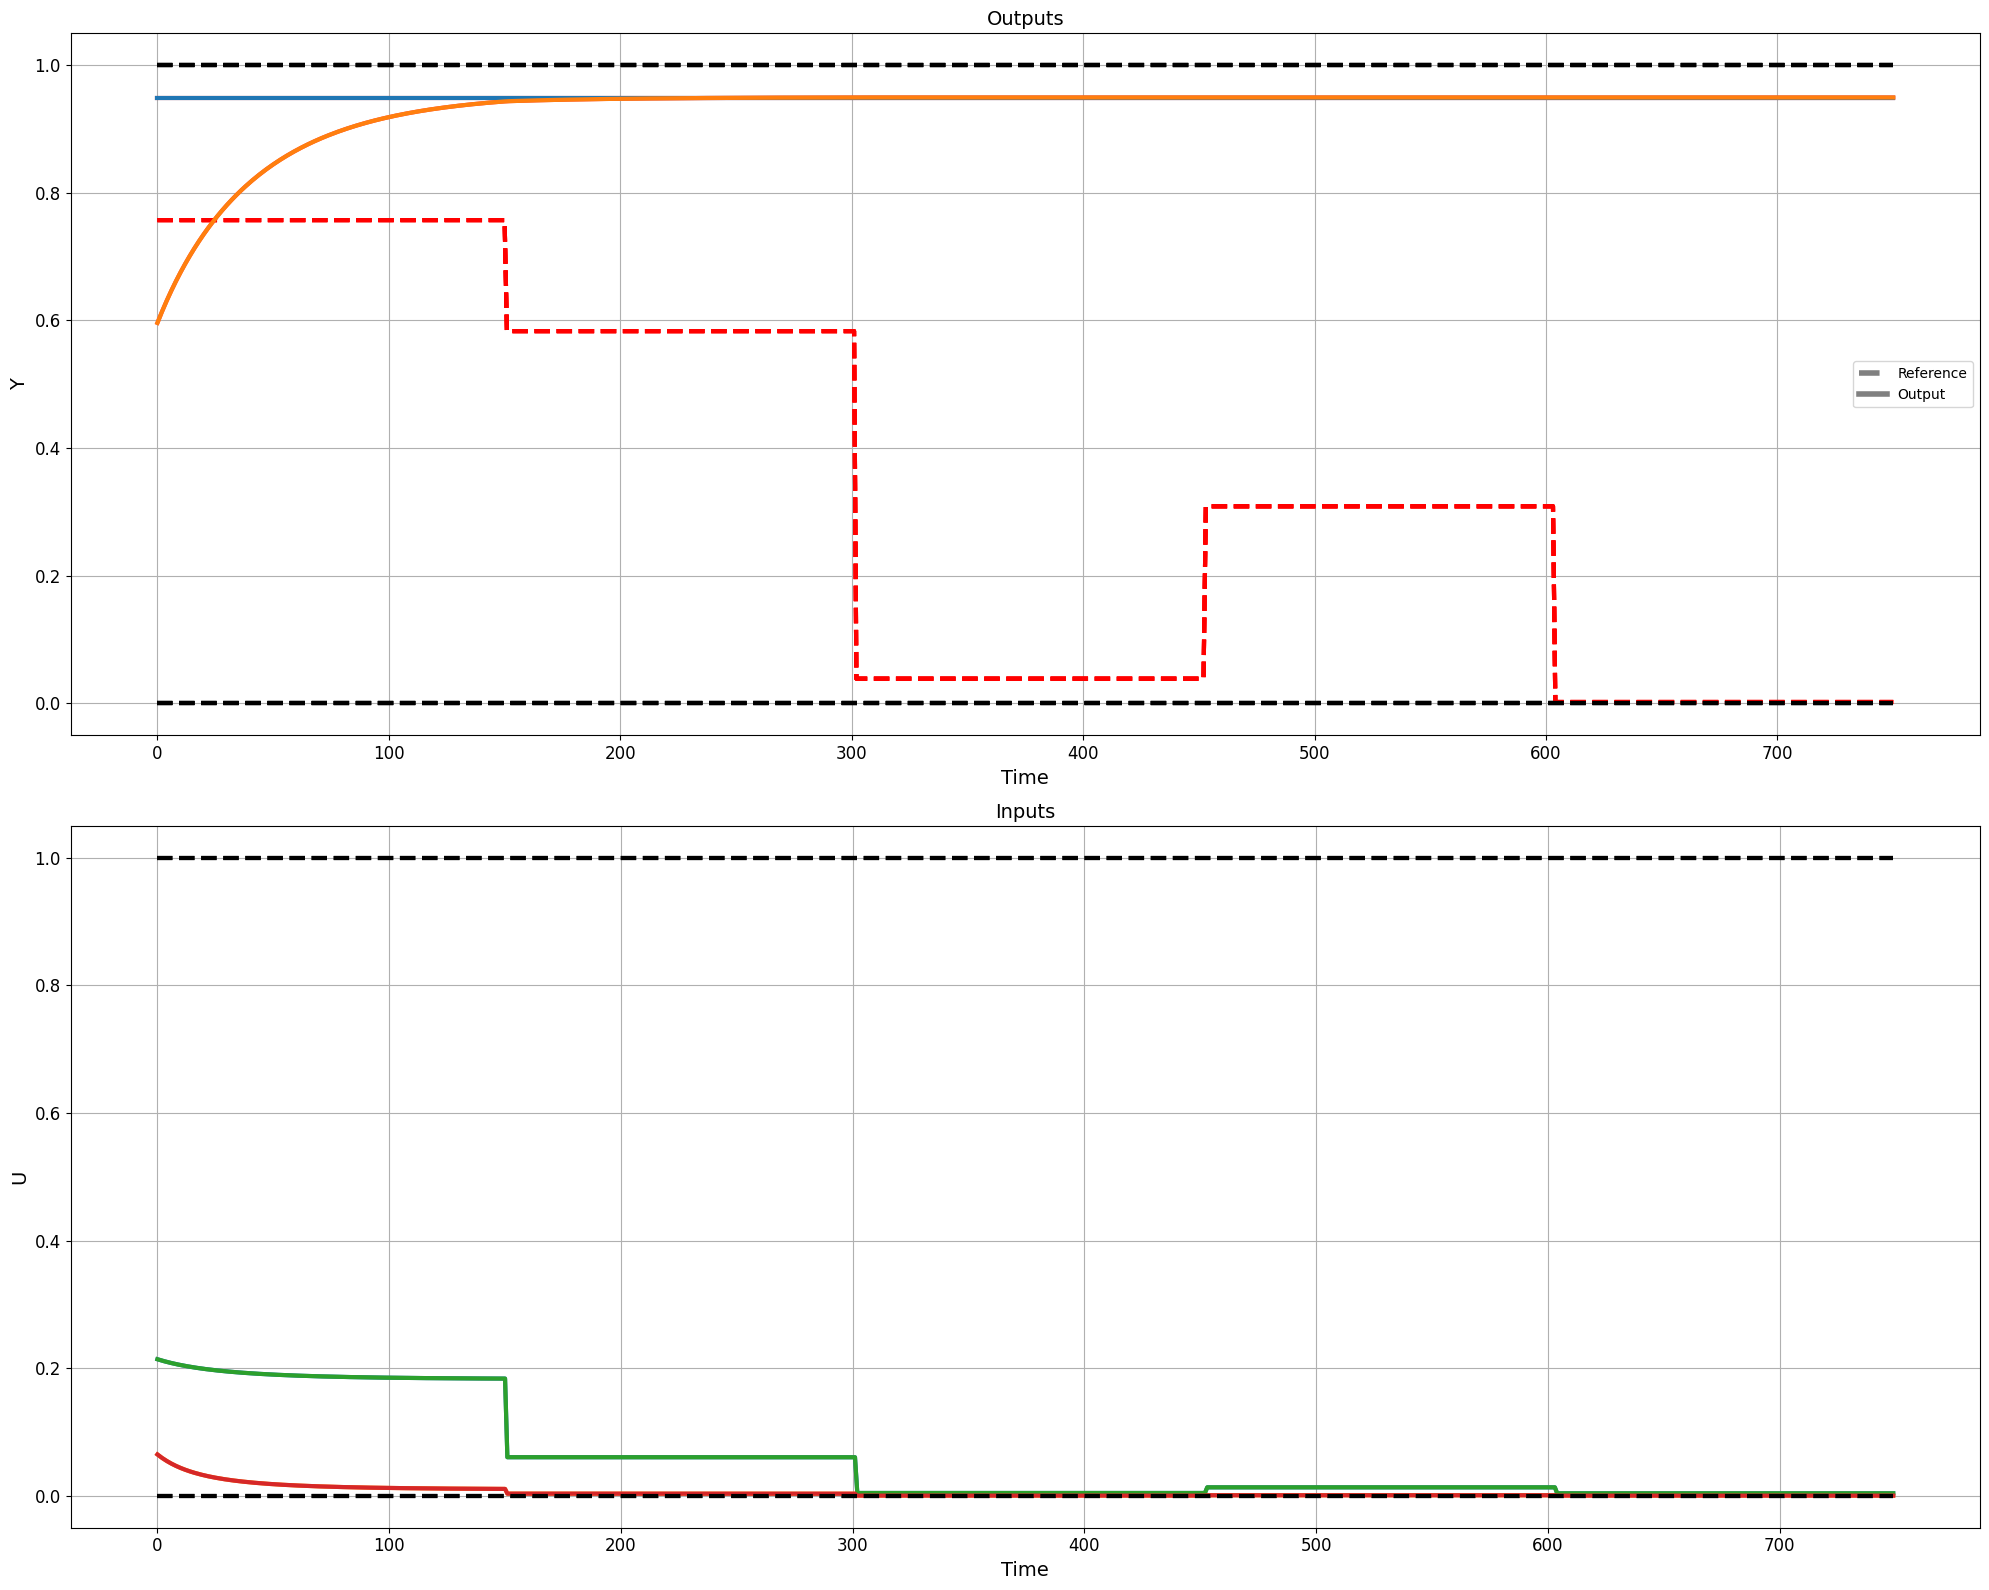

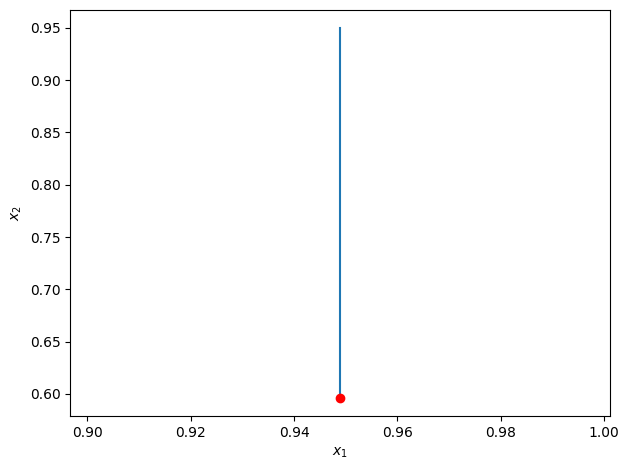

<Figure size 640x480 with 0 Axes>

In [9]:
nsteps = 750
step_length = 150
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=5)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'x': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['x'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax,
      figname='cl.png')
# plot phase portrait
pltPhase(X=trajectories['x'].detach().reshape(nsteps + 1, nx),
         figname='phase.png')
